In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops, dense_to_sparse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import scipy.io as spio

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

from evaluation import accuracy
from evaluation import areaundercurve
from evaluation import average_precision_score_computation

Using matplotlib backend: agg


In [2]:
class NaiveConv(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(NaiveConv, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(in_channel, out_channel),
            torch.nn.Tanh()
        )
        
    def forward(self, x, adj):
        h = self.layers(x)
        x = torch.mm(
            adj,
            h
        )
        return x

class Net(torch.nn.Module):
    def __init__(self, in_channel, out_channel, data):
        super(Net, self).__init__()
        
        self.conv1 = NaiveConv(in_channel, 16)
        self.conv2 = NaiveConv(16, out_channel)
        
        injection = torch.ones_like(data.adj) * 0.01
        injection = torch.abs(injection)
        self.injection = torch.nn.Parameter(
            injection, 
            requires_grad=True
        )
        
    def forward(self, data):
        x, adj = data.x, data.adj
        
        injection = F.relu(self.injection)
        adj = adj + injection
        adj = torch.clamp(adj, 0, 1)
    
        x = self.conv1(x, adj)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, adj)
        return F.log_softmax(x, dim=1)

In [3]:
from tqdm import tqdm

NUMEPOCHS = 10000
early_stop_win_size = 100
tolerance = 0.005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data
name = 'Cora'
dataset = Planetoid('../datasets/'+ name, name=name)

in_dim = dataset.num_node_features
out_dim = dataset.num_classes

data = dataset.data
data.adj = to_dense_adj(add_self_loops(data.edge_index)[0])[0]
data = dataset.data.to(device)

# compile model
model = Net(
    in_dim,
    out_dim,
    data
).to(device)

optimizer = torch.optim.Adamax(model.parameters(), weight_decay=0.001)

In [4]:
# get the initial injection
injection_init = model.injection.detach().cpu().numpy()

In [5]:
%%time

# record accuracy
train_acc = np.zeros(NUMEPOCHS)
val_acc = np.zeros(NUMEPOCHS)
test_acc = np.zeros(NUMEPOCHS)

# training start
model.train()

for epoch in range(NUMEPOCHS):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    # record the accuracy
    train_acc[epoch] = accuracy(model, data, 'train')
    val_acc[epoch] = accuracy(model, data, 'val')
    test_acc[epoch] = accuracy(model, data, 'test')
    
    # early stopping
    if epoch > 2 * early_stop_win_size:
        prev_start = epoch - 2 * early_stop_win_size
        prev_end = epoch - early_stop_win_size
        current_start = epoch - early_stop_win_size
        current_end = epoch
        
        val_acc_current = np.mean(val_acc[current_start: current_end])
        val_acc_previous = np.mean(val_acc[prev_start: prev_end])
        
        if val_acc_current < val_acc_previous - tolerance:
            train_acc = train_acc[:epoch]
            val_acc = val_acc[:epoch]
            test_acc = test_acc[:epoch]
            print('Moving Average Early stopping at %d-th epoch' % epoch)
            print(
                'Previous validation average accuracy for %d-th to %d-th epoch: %f' % \
                (prev_start, prev_end, val_acc_previous)
            )
            print(
                'Current validation average accuracy for %d-th to %d-th epoch: %f' % \
                (current_start, current_end, val_acc_current)
            )
            break
    
    if epoch % 1000 == 0:
        print(
            epoch, 
            'training acc =', train_acc[epoch], 
            ', loss =', loss.item()
        )

0 training acc = 0.14285714285714285 , loss = 21.979896545410156
1000 training acc = 1.0 , loss = 0.008078125305473804
2000 training acc = 1.0 , loss = 0.003994761034846306
3000 training acc = 1.0 , loss = 0.0024729252327233553
4000 training acc = 1.0 , loss = 0.0016196761280298233
5000 training acc = 1.0 , loss = 0.0010657821549102664
6000 training acc = 1.0 , loss = 0.0008451002067886293
7000 training acc = 1.0 , loss = 0.0007543666288256645
8000 training acc = 1.0 , loss = 0.0007222346030175686
Moving Average Early stopping at 8434-th epoch
Previous validation average accuracy for 8234-th to 8334-th epoch: 0.767720
Current validation average accuracy for 8334-th to 8434-th epoch: 0.762700
CPU times: user 5min 13s, sys: 1min 48s, total: 7min 2s
Wall time: 7min 2s


In [6]:
# get the initial injection
injection_final = F.relu(model.injection.detach()).cpu().numpy()

In [7]:
print('Initial injection = \n', injection_init)
print('\nSum inital = %d\n' % np.sum(injection_init))
print('Final injection = \n', injection_final)
print('\nSum final = %d\n' % np.sum(injection_final))

Initial injection = 
 [[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]]

Sum inital = 73333

Final injection = 
 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 8.1440696e-04
  6.2714075e-03 7.0080692e-03]
 [0.0000000e+00 4.8333669e-07 6.8101207e-07 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 9.5007231e-04 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 6.7333867e-06]
 ...
 [0.0000000e+00 6.3249645e-05 4.3947093e-05 ... 0.0000000e+00
  0.0000000e+00 7.5389139e-06]
 [1.4279960e-04 0.0000000e+00 1.5945985e-05 ... 3.0643267e-05
  6.0462182e-05 0.0000000e+00]
 [9.7285105e-05 4.5645302e-05 1.6530583e-05 ... 3.5373196e-05
  3.2699797e-06 1.0045608e-05]]

Sum final = 815



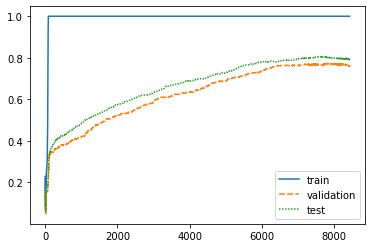

In [8]:
df_acc = pd.DataFrame({
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

sns.lineplot(data=df_acc)
plt.show()

In [9]:
spio.savemat('../variables/' + name + '/GNN.mat',{
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

In [10]:
print('Train Accuracy: {:.4f}'.format(accuracy(model, data, 'train')))
print('Validation Accuracy: {:.4f}'.format(accuracy(model, data, 'val')))
print('Test Accuracy: {:.4f}'.format(accuracy(model, data, 'test')))

Train Accuracy: 1.0000
Validation Accuracy: 0.7600
Test Accuracy: 0.7910


In [11]:
print('Test AUC: {:.4f}'.format(areaundercurve(model,data,'test')))

Test AUC: 0.8892


In [12]:
test_acc_all = np.array([0.7960, 0.8000, 0.7980, 0.7950, 0.8030])
test_auc_all = np.array([0.8909, 0.8952, 0.8969, 0.8926, 0.8970])

print(np.mean(test_acc_all))
print(np.mean(test_auc_all))

print(np.std(test_acc_all))
print(np.std(test_auc_all))

0.7984
0.89452
0.002870540018881467
0.0024111408088288936
